In [2]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
from metpy.plots import ctables
from pyPIPS import disdrometer_module as dis
from pyPIPS import timemodule as tm
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [34]:
# global constants, etc.
from scipy.constants import c

# Function definitions

# Based on Robin's code

# Some small functions needed throughout
# Source: 
# https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
def nearest(items, pivot):
    """ Finds closest object to 'pivot' in list 'items' """
    return min(items, key=lambda x: abs(x - pivot))

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: categories[val+1])

# My favorite blue-to-red colormap    
cdict1 = {'red':  ((0.0, 0.0, 0.0),
                   (0.3, 0.0, 0.0),
                   (0.5, 1.0, 1.0),
                   (0.7, 0.9, 0.9),
                   (1.0, 0.4, 0.4)),

         'green': ((0.0, 0.0, 0.0),
                   (0.3, 0.0, 0.0),
                   (0.5, 1.0, 1.0),
                   (0.7, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.4, 0.4),
                   (0.3, 0.9, 0.9),
                   (0.5, 1.0, 1.0),
                   (0.7, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)

# Custom black-blue-red colormap for hydrometeor classification
hydroclass3 = LinearSegmentedColormap.from_list('hydroclass3', \
                                                [(1, 0, 0), (0, 0, 1), (1, 1, 1)], N=3)

# Colormap for reflectivity that goes to blue instead of black
plasma_white = LinearSegmentedColormap.from_list('plasma_white', \
                                                 ['white','purple','red','yellow'], \
                                                 N=256)


def read_fmcw_xarray(filename):
    """Reads an FMCW netCDF file into an xarray DataSet"""
    
    fmcw_dataset = xr.open_dataset(filename)
    # Rename a couple of the variables to the same name as the dimensions
    # and assign them as coordinates
    fmcw_dataset = fmcw_dataset.rename({'secs': 'time', 'gate': 'height'})
    fmcw_dataset = fmcw_dataset.set_coords(['time', 'height'])
    
    # Fix the 'units' attribute of the new time coordinate so that it can be
    # decoded into datetime objects
    fmcw_dataset['time'].attrs['units'] = fmcw_dataset['time'].attrs.pop('Units')
    fmcw_dataset['time'].attrs['units'] = 'seconds since 1-1-1970'
    fmcw_dataset = xr.decode_cf(fmcw_dataset)
    
    # Add new Wavelength and Nyquist velocity attributes
    
    fmcw_dataset.attrs['Wavelength'] = c/fmcw_dataset.Frequency
    fmcw_dataset.attrs['Vmax'] = fmcw_dataset.PRF * fmcw_dataset.Wavelength / 4.

    return fmcw_dataset


def read_fmcw(filename):
    """
    Reads basic (moment) variables from a UMass FMCW NetCDF file.
    
    Input: 
        fileName : string
           Name of the UMass FMCW data NetCDF file
    Output: 
        A dictionary with the following arrays keyed by the array name:
        
        height : array
            Height (m AGL)
        vbins : array
            Spectral Velocity Bins (m/s)
        UTCtime : array
            Time in UTC (24-hr)
        Ze : array
            Logarithmic reflectivity factor (dBZ)
        vel : array
            Mean Radial Velocity (m/s)
        wid : array
            Spectrum Width (m/s)
        snr : array
            Signal-to-noise ratio (dB)
        PRF : float
            Pulse repetition frequency (Hz)
        Frequency : float
            Radar frequency (Hz)
        Wavelength : float
            Radar wavelength (m)
        Vmax : float
            Maximum unambiguous (Nyquist) velocity (m/s)
    """
    data = netcdf.Dataset(filename, "r")
    height = data.variables['height'][:]
    vbins = data.variables['vbins'][:]
    secs = data.variables['secs'][:]
    Ze = data.variables['Ze'][:]/10.
    ZeName = data.variables['Ze'].Name
    vel = data.variables['vel'][:]
    velName = data.variables['vel'].Name
    wid = data.variables['wid'][:]
    widName = data.variables['wid'].Name
    snr = data.variables['snr'][:]/10.
    snrName = data.variables['snr'].Name
    PRF = data.PRF
    Frequency = data.Frequency
    
    data.close()
    # Convert frequency to wavelength
    Wavelength = c/Frequency
    # Nyquist velocity
    Vmax = PRF * Wavelength / 4.    
    # Convert secs (number of seconds since epoch) into UTC time
    UTCtime = []
    for s in secs:
        UTCtime.append(datetime(1970, 1, 1, 0, 0, 0) + timedelta(0, int(s)))
    UTCtime = np.array(UTCtime)
    return {'height': height, 'vbins': vbins, 'UTCtime': UTCtime, 'Ze': (ZeName, Ze), 
            'vel': (velName, vel), 'wid': (widName, wid), 'snr': (snrName, snr), 
            'PRF': PRF, 'Frequency': Frequency, 'Wavelength': Wavelength, 'Vmax': Vmax}


def get_fmcw_filepaths(basedir, starttimestring, endtimestring):
    """Gets a list of FMCW file paths given a base directory and a starttime and endtime"""
    timeformat = '%Y%m%d%H%M'
    
    starttime = datetime.strptime(starttimestring, timeformat)
    endtime = datetime.strptime(endtimestring, timeformat)
    
    delta = endtime - starttime
    totalhours = int(delta.days * 24 + delta.seconds/3600)

    delta_day_bounds = (endtime.date() - starttime.date()).days

    datetimerange = [starttime + timedelta(hours=x) for x in range(0, totalhours + 1)]
    daterange = [starttime.date() + timedelta(days=x) for x in range(0, delta_day_bounds + 1)]

    subdir_template = "{:02d}{:02d}"
    subdirs = [subdir_template.format(x.month, x.day) for x in daterange]


    filename_format = 'S{:04d}{:02d}{:02d}T{:02d}' 
    filename_templates = [filename_format.format(x.year, x.month, x.day, x.hour) for x in datetimerange]
    
    ncfiles2d = []
    for subdir in subdirs:
        absdir = os.path.join(fmcw_data_dir, subdir)
        ncfiles2d.append(glob(absdir + '/*nc'))

    ncfiles = list(itertools.chain.from_iterable(ncfiles2d))

    pathlist = [f for f in ncfiles if any(m in f for m in filename_templates)]

    return pathlist


# def combine_fmcw_xr_datasets(datasets):
#     """Combines dictionaries containing FMCW data read in from multiple files into a single dictionary"""
    
#     combined_dict = {}
#     for data_dict in data_dictlist:
#         for varname in data_dict:
            


def plot_fmcw_4panel(fileName):
    """Basic four-panel plot of file contents."""
    
    data_dict = read_fmcw(fileName)
    
#     height, vbins, UTCtime, Ze, vel, wid, snr, PRF, Frequency, Wavelength, Vmax, \
#         ZeName, velName, widName, snrName = readfmcw_more(fileName)
    
    height = data_dict['height']
    Vmax = data_dict['Vmax']
    UTCtime = data_dict['UTCtime']
    ZeName, Ze = data_dict['Ze']
    velName, vel = data_dict['vel']
    widName, wid = data_dict['wid']
    snrName, snr = data_dict['snr']
    
    if fileName[-18:-14] == "2017": Vmax = 7.3  # 2017 data were collected with a 
    # solid state amplifier that had a larger Nyquist interval than the default 
    # +/-4.9 m/s.
    
    # 4-panel plot of output
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(8.5,4.75)
    fig.subplots_adjust(bottom=0.15) # Keeps xlabel from getting chopped off
    fig.subplots_adjust(wspace=0.05) # Expand subplots slightly in the horizontal
    
    # Reflectivity (Ze)
    m1 = ax[0, 0].pcolormesh(UTCtime, height/1000., Ze.T,cmap=plasma_white, \
                             vmin=-30., vmax=30.)
    ax[0, 0].set_title("(a) " + ZeName + " (dBZ)")
    ax[0, 0].set_ylim(np.min(height/1000.), np.max(height/1000.))
    ax[0, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[0, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    #ax[0, 0].set_xlabel("Time (UTC)")
    ax[0, 0].set_ylabel("Height (km AGL)")
    plt.colorbar(m1,ax=ax[0, 0])
    
    # Doppler (vertical) velocity (vel)
    m2 = ax[0, 1].pcolormesh(UTCtime,height/1000., vel.T, cmap=cm.RdBu_r, \
                             vmin=-1.*np.ceil(Vmax), vmax=np.ceil(Vmax))
    ax[0, 1].set_title("(b) " + velName + r" (m s$^{-1}$)")
    ax[0, 1].set_ylim(np.min(height/1000.),np.max(height/1000.))
    ax[0, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[0, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    #ax[0, 1].set_xlabel("Time (UTC)")
    #ax[0, 1].set_ylabel("Height (km AGL)")
    plt.colorbar(m2,ax=ax[0, 1])
    
    # Spectrum width (wid)
    m3 = ax[1, 0].pcolormesh(UTCtime, height/1000., wid.T, cmap=cm.BuPu, \
                             vmin=0., vmax=5.)
    ax[1, 0].set_title("(c) " + widName + r" (m s$^{-1}$)")
    ax[1, 0].set_ylim(np.min(height/1000.),np.max(height/1000.))
    ax[1, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[1, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    ax[1, 0].set_xlabel("Time (UTC)")
    ax[1, 0].set_ylabel("Height (km AGL)")
    plt.colorbar(m3,ax=ax[1, 0])
    
    # SNR (db)
    m4 = ax[1, 1].pcolormesh(UTCtime, height/1000., snr.T, cmap=cm.viridis, \
                             vmin=-20., vmax=30.)
    ax[1, 1].set_title("(d) " + snrName + " (dB)")
    ax[1, 1].set_ylim(np.min(height/1000.), np.max(height/1000.))
    ax[1, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
    ax[1, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #plt.xticks(rotation=30)
    ax[1, 1].set_xlabel("Time (UTC)")
    #ax[1, 1].set_ylabel("Height (km AGL)")
    plt.colorbar(m4,ax=ax[1, 1])
    
    plt.savefig(fileName[-19:-3] + "_4panel.png",dpi=300)
    
    # Need to have ImageMagick installed on your system for the following command to
    # work. It deletes white space around the edges of the plot (thus saving disk space).
    #os.system("convert -trim " + fileName[-19:-3] + "_4panel.png " + \
    #          fileName[-19:-3] + "_4panel.png")
    
def plot_fmcw_4panel_xarray(dataset):
    """Basic four-panel plot of file contents."""
    
#     height, vbins, UTCtime, Ze, vel, wid, snr, PRF, Frequency, Wavelength, Vmax, \
#         ZeName, velName, widName, snrName = readfmcw_more(fileName)
    if dataset['time'].dt.year[0].item() == 2017: Vmax = 7.3  # 2017 data were collected with a 
    # solid state amplifier that had a larger Nyquist interval than the default 
    # +/-4.9 m/s.
        
    # 4-panel plot of output
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(8.5,4.75)
    fig.subplots_adjust(bottom=0.15) # Keeps xlabel from getting chopped off
    fig.subplots_adjust(wspace=0.05) # Expand subplots slightly in the horizontal
    
    # Reflectivity (Ze)
#     m1 = ax[0, 0].pcolormesh(UTCtime, height/1000., Ze.T,cmap=plasma_white, \
#                              vmin=-30., vmax=30.)

    m1 = dataset['Ze'].plot(x='time', y='height', ax=ax[0, 0], cmap=plasma_white)
    
#     ax[0, 0].set_title("(a) " + ZeName + " (dBZ)")
#     ax[0, 0].set_ylim(np.min(height/1000.), np.max(height/1000.))
#     ax[0, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
#     ax[0, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#     #plt.xticks(rotation=30)
#     #ax[0, 0].set_xlabel("Time (UTC)")
#     ax[0, 0].set_ylabel("Height (km AGL)")
#     plt.colorbar(m1,ax=ax[0, 0])
    
    # Doppler (vertical) velocity (vel)
#     m2 = ax[0, 1].pcolormesh(UTCtime,height/1000., vel.T, cmap=cm.RdBu_r, \
#                              vmin=-1.*np.ceil(Vmax), vmax=np.ceil(Vmax))
    
#     ax[0, 1].set_title("(b) " + velName + r" (m s$^{-1}$)")
#     ax[0, 1].set_ylim(np.min(height/1000.),np.max(height/1000.))
#     ax[0, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
#     ax[0, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#     #plt.xticks(rotation=30)
#     #ax[0, 1].set_xlabel("Time (UTC)")
#     #ax[0, 1].set_ylabel("Height (km AGL)")
#     plt.colorbar(m2,ax=ax[0, 1])
    
#     # Spectrum width (wid)
#     m3 = ax[1, 0].pcolormesh(UTCtime, height/1000., wid.T, cmap=cm.BuPu, \
#                              vmin=0., vmax=5.)
#     ax[1, 0].set_title("(c) " + widName + r" (m s$^{-1}$)")
#     ax[1, 0].set_ylim(np.min(height/1000.),np.max(height/1000.))
#     ax[1, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
#     ax[1, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#     #plt.xticks(rotation=30)
#     ax[1, 0].set_xlabel("Time (UTC)")
#     ax[1, 0].set_ylabel("Height (km AGL)")
#     plt.colorbar(m3,ax=ax[1, 0])
    
#     # SNR (db)
#     m4 = ax[1, 1].pcolormesh(UTCtime, height/1000., snr.T, cmap=cm.viridis, \
#                              vmin=-20., vmax=30.)
#     ax[1, 1].set_title("(d) " + snrName + " (dB)")
#     ax[1, 1].set_ylim(np.min(height/1000.), np.max(height/1000.))
#     ax[1, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
#     ax[1, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#     #plt.xticks(rotation=30)
#     ax[1, 1].set_xlabel("Time (UTC)")
#     #ax[1, 1].set_ylabel("Height (km AGL)")
#     plt.colorbar(m4,ax=ax[1, 1])
    
#     plt.savefig(fileName[-19:-3] + "_4panel.png",dpi=300)
    
    # Need to have ImageMagick installed on your system for the following command to
    # work. It deletes white space around the edges of the plot (thus saving disk space).
    #os.system("convert -trim " + fileName[-19:-3] + "_4panel.png " + \
    #          fileName[-19:-3] + "_4panel.png")

In [11]:
fmcw_data_dir = '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/'
starttimestring = '201604292100'
endtimestring = '201604300300'

filepaths = get_fmcw_filepaths(fmcw_data_dir, starttimestring, endtimestring)
print(filepaths)

['/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T220010.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T230008.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T210001.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T010009.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T030000.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T020010.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T000151.nc']


In [13]:
datasets = []
for file in filepaths:
    print("Reading " + file)
    datasets.append(read_fmcw_xarray(file))

Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T220010.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T230008.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T210001.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T010009.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T030000.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T020010.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T000151.nc


In [14]:
fmcw_merged_dataset = xr.combine_by_coords(datasets)

In [27]:
fmcw_merged_dataset['time'].dt.year[0].item()

2016

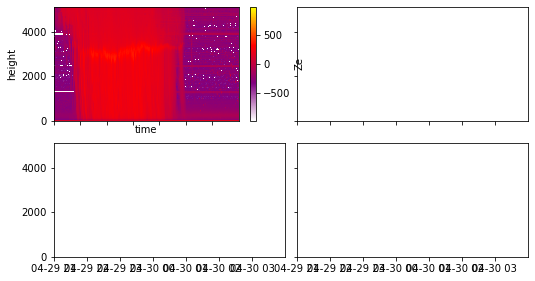

In [35]:
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
plot_fmcw_4panel_xarray(fmcw_merged_dataset)